<a id="step0"></a>
<font color = "#8487c4"><h2>Step 0. Exploring the dataset</h2></font>

<font face="Times New Roman" color="Teal"><center><h1>Neural Networks Project</h1></center></font>
<font face="Times new roman" color="pink"><h4>Dataset:</h4></font>
<b>MAGIC gamma telescope radiation</b><br>
This dataset contains information about the radiations captured by the Chrenkov gamma telescope and the purpose is to classify the photons collected to:
- Primary Gammas (signal)
- Hardonic showers (background)<br><br>
The dataset can be found <a href="https://archive.ics.uci.edu/dataset/159/magic+gamma+telescope">here</a> 

In [94]:
# code to ignore warnings
import warnings

warnings.filterwarnings('ignore')
# import the necessary libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### Table of contents
- [Step 0. Exploring the dataset](#step0)
- [Step 1. Prepping the data](#step1)
- [Step 2. Visualization](#step2)
- [Step 3. Constructing the model](#step3)
    * [First Network](#ann1)
    * [Second Network](#ann2)
    * [Third Network](#ann3)


In [95]:
# loading the dataset 
data = pd.read_csv("magic gamma telescope/magic04_data.csv")

In [96]:
data.head()

fLenght    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans  \
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027   
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160   
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513   
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   

    fAlpha     fDist class  
0  40.0920   81.8828     g  
1   6.3609  205.2610     g  
2  76.9600  256.7880     g  
3  10.4490  116.7370     g  
4   4.6480  356.4620     g

In [97]:
print("Size of the dataset = ", data.shape[0])
print("Number of features = ", data.shape[1]-1)

Size of the dataset =  19020
Number of features =  10


We have 10 features:<br>
1.  `fLength`: major axis of ellipse [mm]
2.  `fWidth`: minor axis of ellipse [mm] 
3.  `fSize`: 10-log of sum of content of all pixels [in #phot]
4.  `fConc`: ratio of sum of two highest pixels over fSize  [ratio]
5.  `fConc1`: ratio of highest pixel over fSize  [ratio]
6.  `fAsym`: distance from highest pixel to center, projected onto major axis [mm]
7.  `fM3Long`: 3rd root of third moment along major axis  [mm] 
8.  `fM3Trans`: 3rd root of third moment along minor axis  [mm]
9.  `fAlpha`: angle of major axis with vector to origin [deg]
10.  `fDist`: distance from origin to center of ellipse [mm]

Looking at the class distribution:<br>
we have 2 classes `gamma` (signal) and `hadron` (background)

In [98]:
# finding the number of samples in each class 
print('number of gamma: ', len(data[data['class']=='g']))
print('number of hadron: ', len(data[data['class']!='g']))

number of gamma:  12332
number of hadron:  6688


#### Checking for duplicates and missing values

In [99]:
# check for duplicates
print('number of duplicated values: ', sum(data.duplicated()))

number of duplicated values:  115


In [100]:
# removing duplicated values 
data.drop_duplicates(inplace=True)
print('number of duplicated values: ', sum(data.duplicated()))

number of duplicated values:  0


In [101]:
# check for missing data
data.isnull().sum()

fLenght     0
fWidth      0
fSize       0
fConc       0
fConc1      0
fAsym       0
fM3Long     0
fM3Trans    0
fAlpha      0
fDist       0
class       0
dtype: int64

<hr>

<a id="step1"></a>
<font color = "#8487c4"><h2>Step 1. Prep the data</h2></font>

### Split the features and target columns into different dataframes

In [102]:
features = data.drop('class', axis=1, inplace=False)
target = data['class']

### Apply train/test split
Where we have `30%` for testing, `70%` for training.<br>
from the training set we will take `15%` for valiation.

In [103]:
# splitting the dataset into training and testing 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

In [104]:
# split th train dataset into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15, random_state=42)

### Make the preprocessing pipeline
<b>Imputing missing values:</b> 
* for <i>Numerical</i> values: replace the missing values by the mean<br>
<b>why the <i>mean</i>?</b> because if we replace them by 0 for example (which is a min value) it would have a significant effect on the analysis, however the mean value makes it as signifacnt as a lot of the other values and thus not afecting my prediction either way.
* for <i>Categorical</i> values: replace the missing values by the most frequent
<h3> Numerical values: Scaling </h3>
<u>StandardScaler():</u> <br>
- less sensitive to outliers<br>
- isn't influenced by the global max and min<br>
- scales features by removing the mean and scaling to unit variance. This results in a transformation where the mean of the rescaled features becomes 0 with a standard deviation of 1.
<h3> Categorical values: Encoding</h3>
<u>LabelEncoder()</u>

In [105]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# create 2 pipelines:
# One to deal with the numeric features 
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # imputing the missing values with the mean
    ('scaler', StandardScaler())  # scaling the data with the standard scaler
])
# the other to deal with the categorical features
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # replace missing values by the mode
    ('encoder', LabelEncoder())  # encode categ. values using label encoder
])

Now we combine the two pipelines into on using the `ColumnTransformer` 

In [106]:
from sklearn.compose import ColumnTransformer

# aggregate the two pipelines into one single pipeline
full_pipe_preprocessing = ColumnTransformer([
    ('numeric pipe', numeric_pipeline, x_train.select_dtypes(include='number').columns.tolist()),
    ('categorical pipe', categorical_pipeline, x_train.select_dtypes(exclude='number').columns.tolist())
])

Using the pipeline to preprocess the **x_train** and **x_val**

In [107]:
x_train_prep = full_pipe_preprocessing.fit_transform(x_train)
x_val_prep = full_pipe_preprocessing.fit_transform(x_val)

Encoding target variables

In [108]:
y_val_encoded = LabelEncoder().fit_transform(y_val)
y_train_encoded = LabelEncoder().fit_transform(y_train)

<hr>

<a id="step2"></a>
<font color = "#8487c4"><h2>Step 2. Visualization</h2></font>

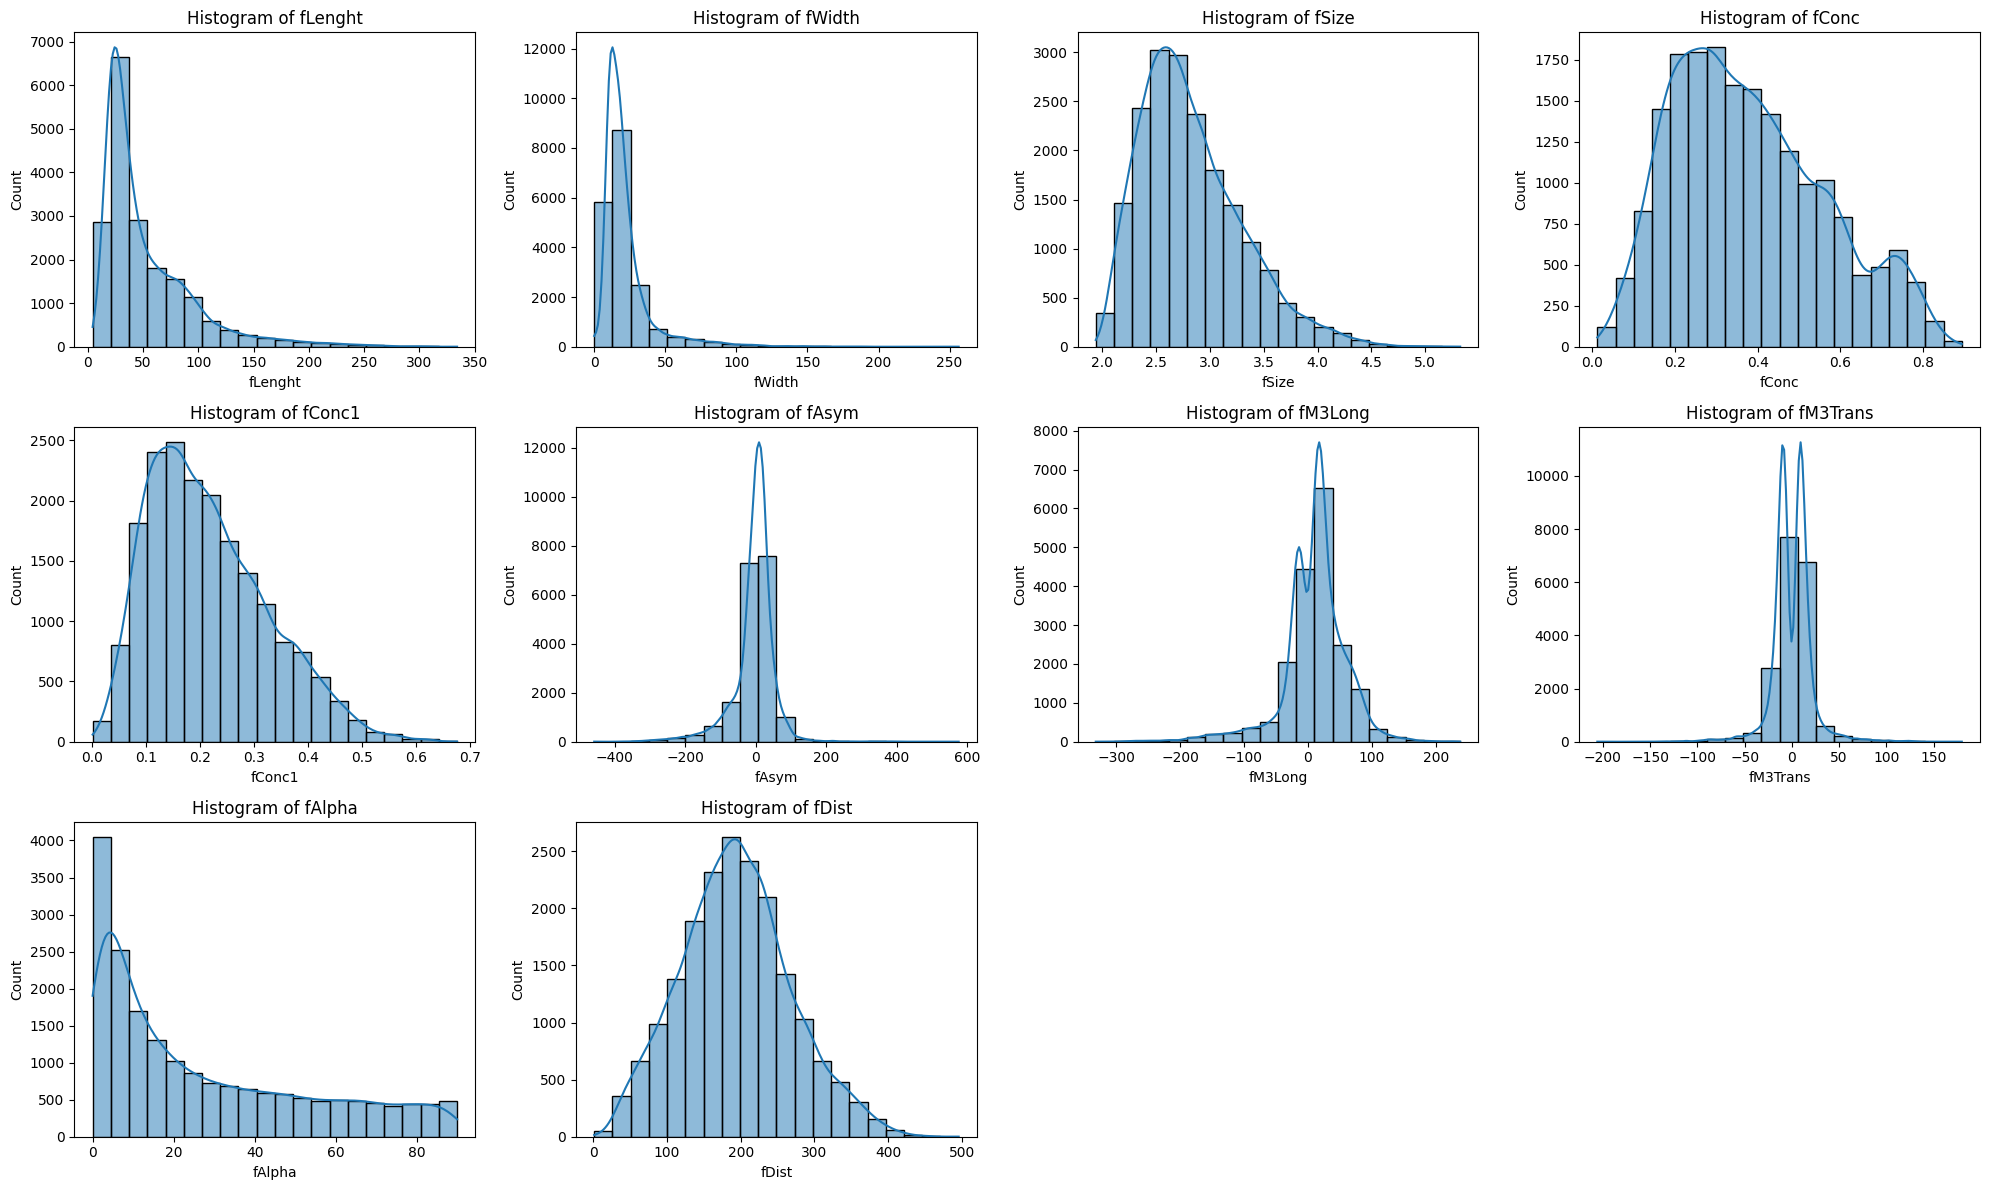

In [109]:
# Histograms for Numeric Features
plt.figure(figsize=(20, 12))
for i, col in enumerate(data.select_dtypes(include='number').columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[col], bins=20, kde=True)
    plt.title(f'Histogram of {col}')
plt.tight_layout()
plt.show()

#### Correlation Heatmap:
A heatmap showing the correlation between numeric features in the dataset.
Correlation values close to 1 or -1 indicate strong positive or negative correlations respectively, while values close to 0 indicate weak or no correlation.

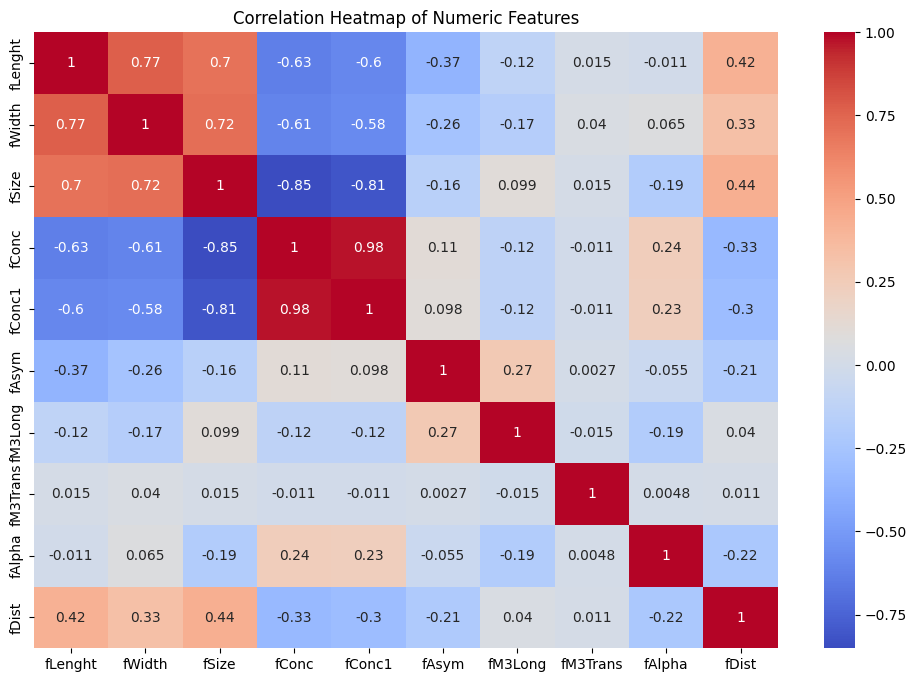

In [110]:
#Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

#### Class Distribution:
A bar plot showing the distribution of classes (gamma and hadron) in the dataset.
This helps visualize the balance or imbalance between different classes.

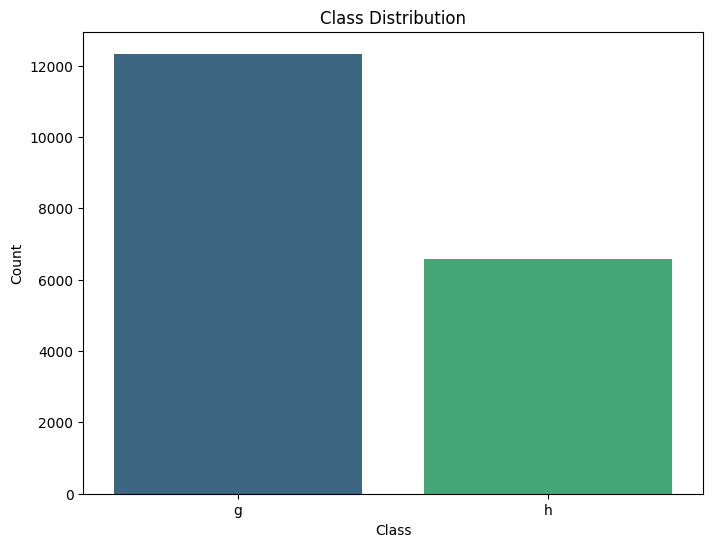

In [111]:
# Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=data, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### Pairplot:
A pairplot showing pairwise relationships between numeric features.
This plot includes histograms along the diagonal and scatter plots for each pair of features, providing a comprehensive view of the relationships in the data.

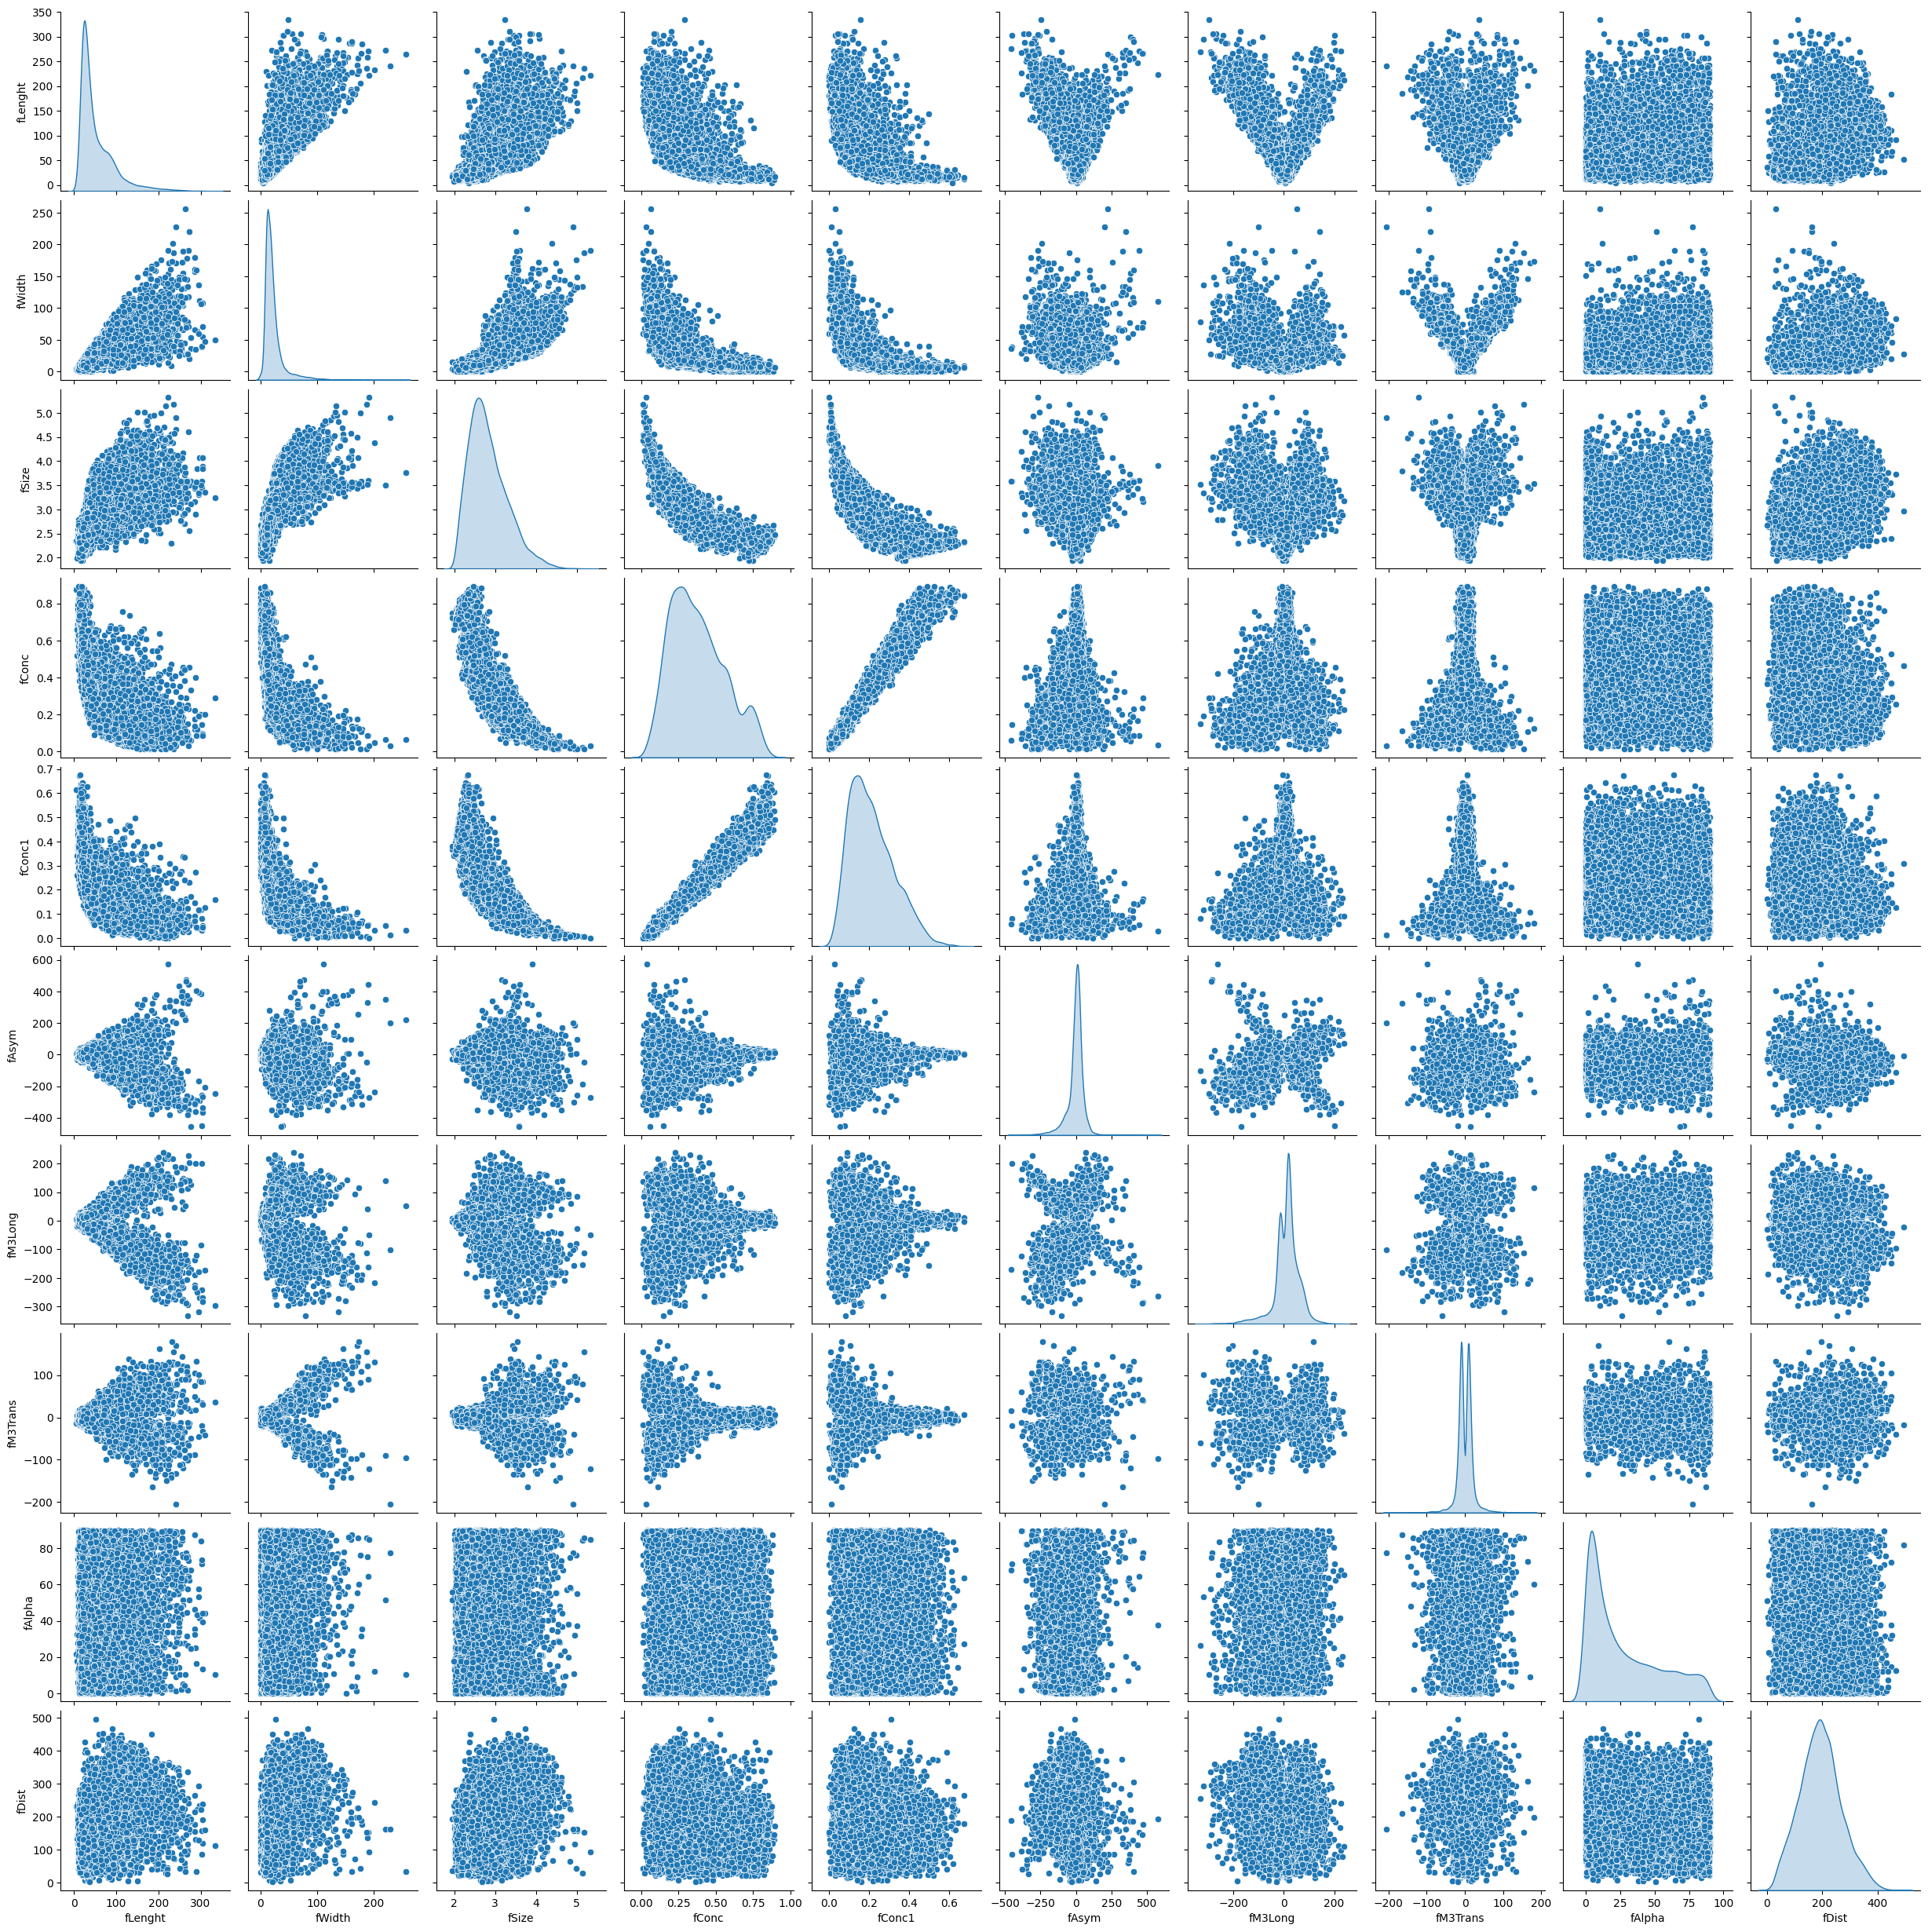

In [112]:
# Pairplot
sns.pairplot(data.select_dtypes(include='number'), diag_kind='kde')
plt.show()

#### Boxplot for Outliers:
For each numeric feature, a boxplot is plotted to visualize the distribution of values and detect potential outliers.
Outliers are data points that significantly differ from other observations in the dataset.

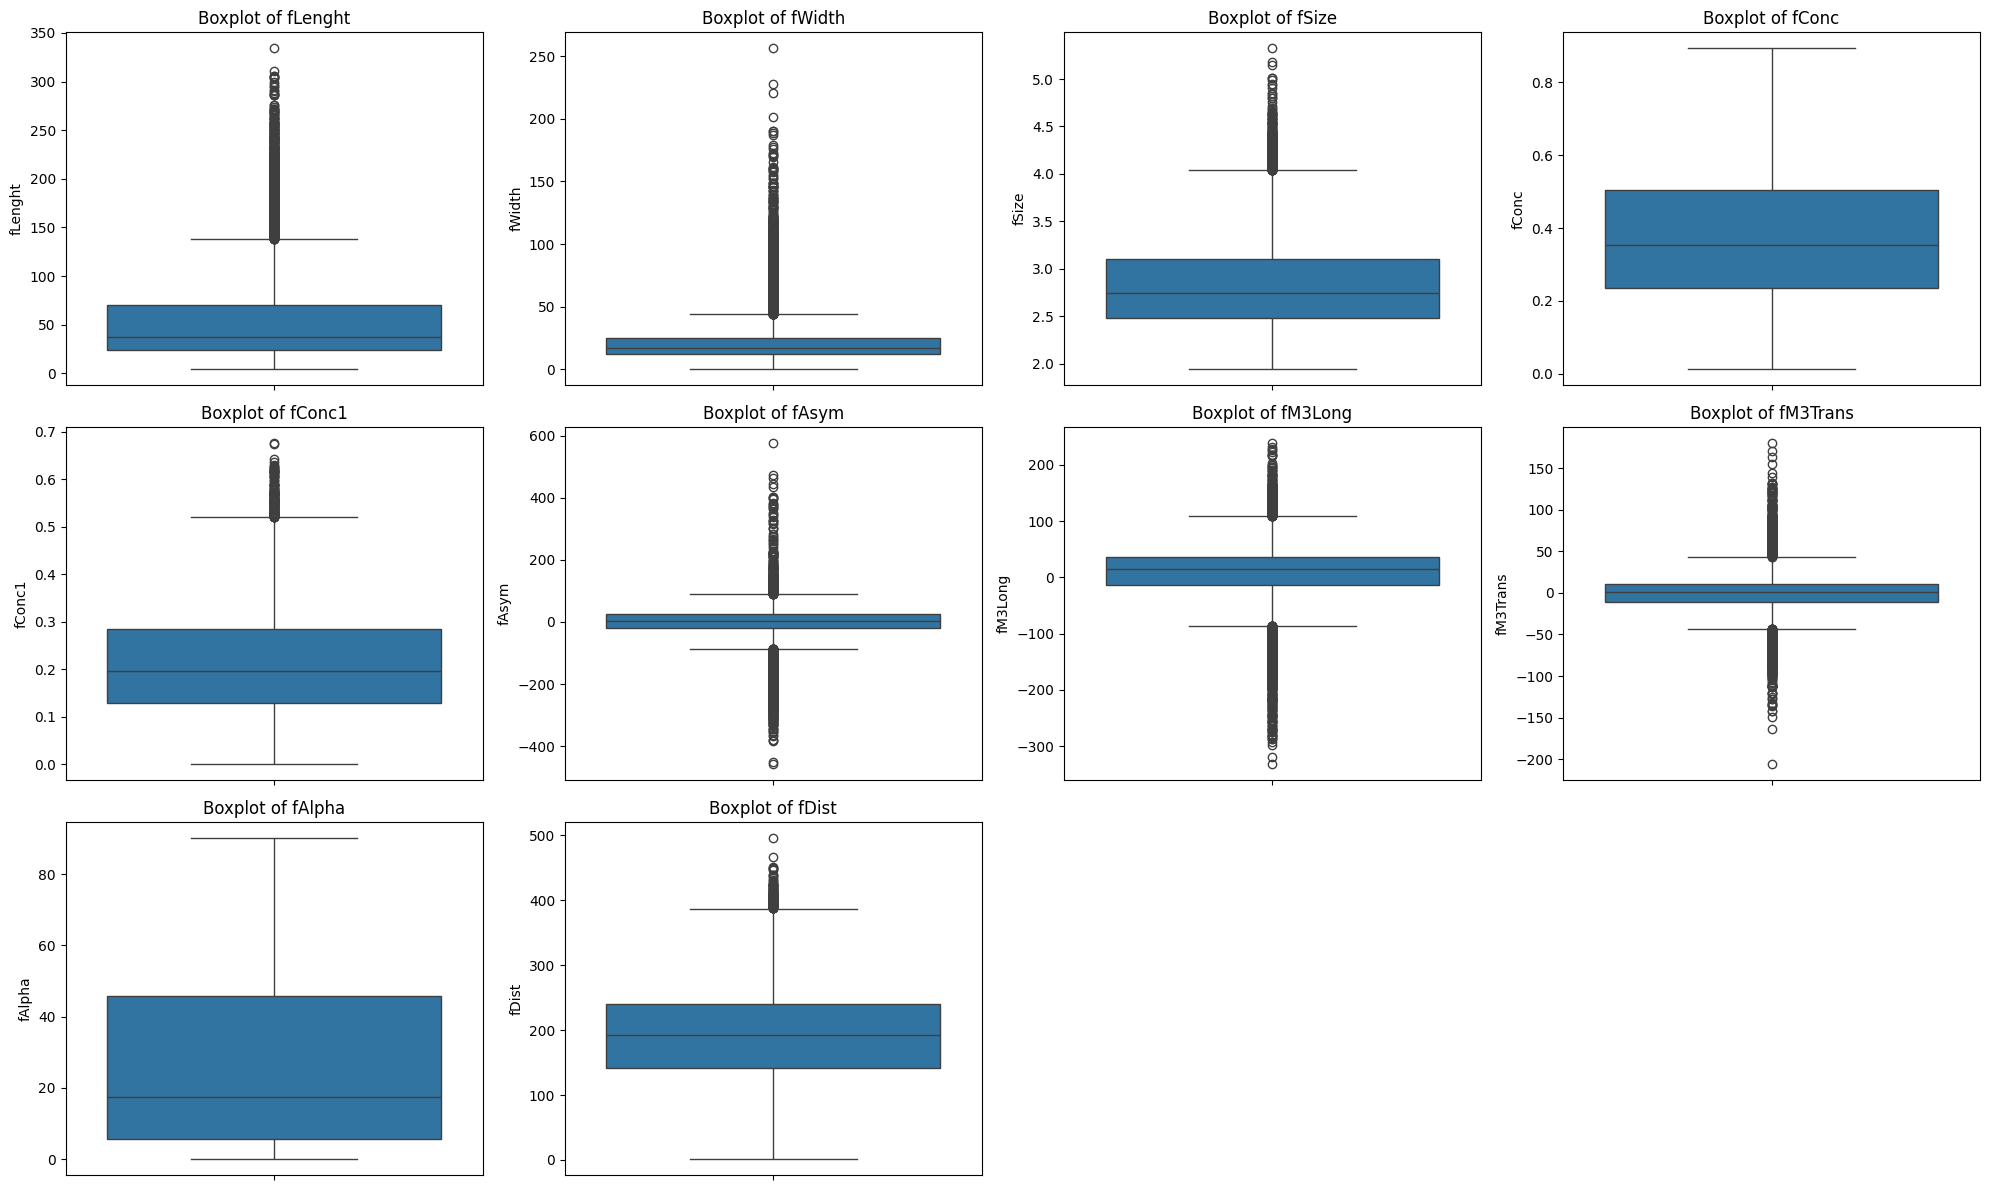

In [113]:
# Boxplot for Outliers
plt.figure(figsize=(20, 12))
for i, col in enumerate(data.select_dtypes(include='number').columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(y=data[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

<hr>

<a id="step3"></a>
<font color = "#8487c4"><h2>Step 3. Constructing the model</h2></font>
We will try 3 different networks and compare the results as well as fine-tuning the learning rate to get optimal performance

<a id="ann1"></a>
<font face="Times new roman" color= "#FF3A7D"><h3>First Network</h3></font>

In [114]:
"""y_train_encoded = LabelEncoder().fit_transform(y_train)
y_val_encoded = LabelEncoder().fit_transform(y_val)"""
y_test_encoded = LabelEncoder().fit_transform(y_test)

In [115]:
import tensorflow as tf
input_shape = [x_train_prep.shape[1]]

model = tf.keras.Sequential([

    tf.keras.layers.Dense(units=5, activation='relu',input_shape=input_shape),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61 (244.00 B)

 Trainable params: 61 (244.00 B)

 Non-trainable params: 0 (0.00 B)

In [116]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=['accuracy'])

In [117]:
# Early stopping callback
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True)


In [118]:
losses = model.fit(x_train_prep, y_train_encoded,
                   validation_data=(x_val_prep, y_val_encoded),
                   epochs=50,
                   callbacks=[early_stopping_monitor]
				          )

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5428 - loss: 0.4615 - val_accuracy: 0.7431 - val_loss: 0.3513
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.7492 - loss: 0.3273 - val_accuracy: 0.7572 - val_loss: 0.2688
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.7864 - loss: 0.2431 - val_accuracy: 0.7844 - val_loss: 0.2351
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.7965 - loss: 0.2237 - val_accuracy: 0.7955 - val_loss: 0.2213
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.8085 - loss: 0.2079 - val_accuracy: 0.7990 - val_loss: 0.2137
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.8148 - loss: 0.1995 - val_accuracy: 0.8015 - val_loss: 0.2087
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.8145 - loss: 0.1964 - val_accuracy: 0.8065 - val_loss: 0.2039
Epoch 8/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8164 - loss: 0.1940 - val_

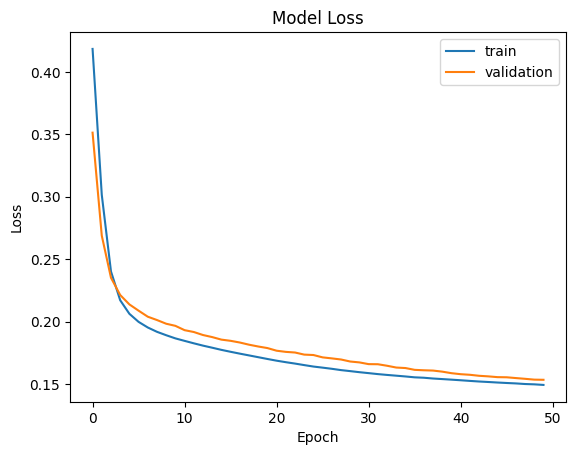

In [119]:
# plot model loss
plt.plot(losses.history['loss'])
plt.plot(losses.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

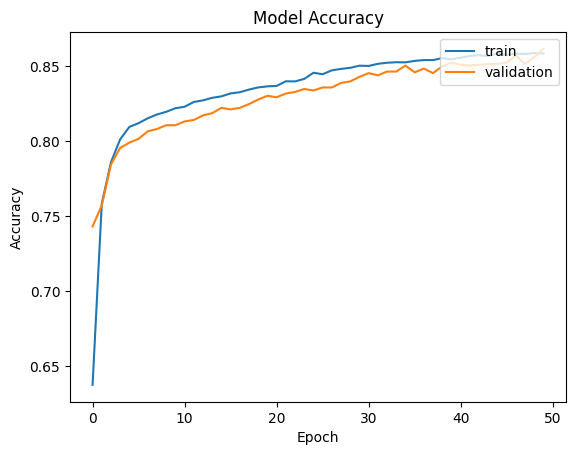

In [120]:
# plot model accuracy
plt.plot(losses.history['accuracy'])
plt.plot(losses.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [121]:
from sklearn.metrics import accuracy_score
# Make predictions on the validation set
scores = model.evaluate(full_pipe_preprocessing.fit_transform(x_val), LabelEncoder().fit_transform(y_val))

# Calculate accuracy
accuracy1 = scores[1]
print("Accuracy:", accuracy1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.8639 - loss: 0.1492
Accuracy: 0.8614609837532043


In [122]:
# Make predictions on the test set
pred = model.predict(x_val_prep)

# Convert predicted class probabilities to class labels
pred_classes = [1 if y>=0.5 else 0 for y in pred]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step


In [123]:
from sklearn.metrics import mean_squared_error
loss1 =mean_squared_error(y_val_encoded, pred_classes)
print("Loss:", loss1)

Loss: 0.1385390428211587


#### 2nd network structure

In [124]:
import tensorflow as tf
input_shape = [x_train_prep.shape[1]]

network = tf.keras.Sequential([

    tf.keras.layers.Dense(units=64, activation='relu',
                          input_shape=input_shape),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
network.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
network.compile(optimizer='sgd',
              loss='mae',
              metrics=['accuracy'])

In [126]:
losses = network.fit(x_train_prep, y_train_encoded,
        validation_data=(x_val_prep, y_val_encoded),
		    epochs=50,
        callbacks=[early_stopping_monitor]
				)

Epoch 1/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5932 - loss: 0.4743 - val_accuracy: 0.7189 - val_loss: 0.3984
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.7457 - loss: 0.3669 - val_accuracy: 0.7340 - val_loss: 0.3333
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.7536 - loss: 0.3173 - val_accuracy: 0.7537 - val_loss: 0.2974
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.7760 - loss: 0.2774 - val_accuracy: 0.7673 - val_loss: 0.2752
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.7899 - loss: 0.2545 - val_accuracy: 0.7733 - val_loss: 0.2605


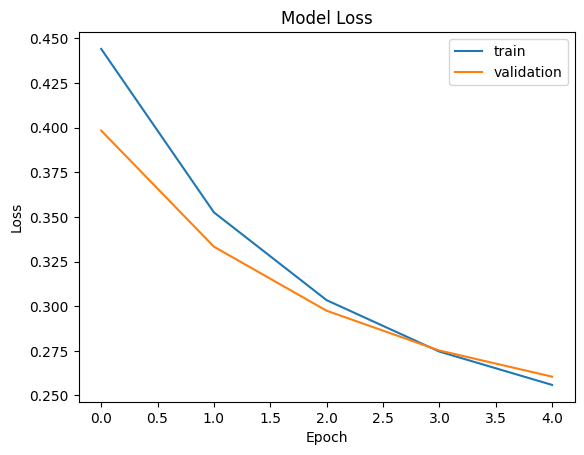

In [127]:
# plot model loss
plt.plot(losses.history['loss'])
plt.plot(losses.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

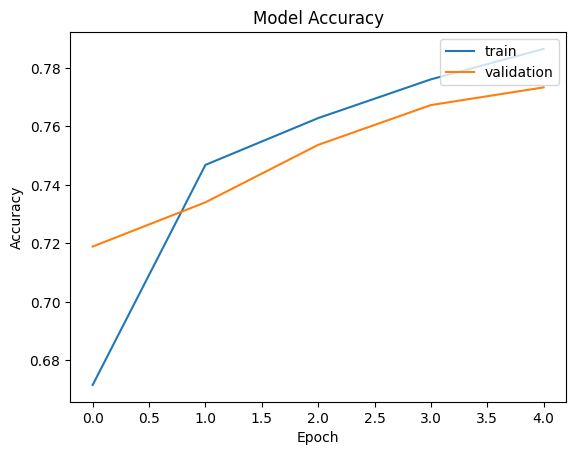

In [128]:
# plot model accuracy
plt.plot(losses.history['accuracy'])
plt.plot(losses.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [129]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
# Make predictions on the validation set
scores2=network.evaluate(full_pipe_preprocessing.fit_transform(x_val), LabelEncoder().fit_transform(y_val))

# Calculate accuracy
accuracy2 = scores2[1]
print("Accuracy:", accuracy2)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.7409 - loss: 0.3875
Accuracy: 0.7188916802406311


In [130]:
from sklearn.metrics import accuracy_score
# Make predictions on the test set
pred = network.predict(x_val_prep)

# Convert predicted class probabilities to class labels
pred_classes = [1 if y>=0.5 else 0 for y in pred]

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, pred_classes)
print("Accuracy:", accuracy)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7188916876574307


In [131]:
loss2 = mean_squared_error(y_val_encoded, pred_classes)
print("Loss:", loss2)

Loss: 0.2811083123425693


In [132]:

model_metrics = {
    "Accuracy": [accuracy1,accuracy2],
    "Loss": [loss1,loss2]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(model_metrics,index=["Model #1", "Model #2"])

# Print the DataFrame
df.head()

Accuracy      Loss
Model #1  0.861461  0.138539
Model #2  0.718892  0.281108

### Deduction
We notice that the first model has the best accuracy of the two 
<br>so we are going to use it for predictions on the test dataset

In [133]:
from sklearn.metrics import accuracy_score
# Make predictions on the test set
pred = model.predict(full_pipe_preprocessing.fit_transform(x_test))

# Convert predicted class probabilities to class labels
pred_classes = [1 if y>=0.5 else 0 for y in pred]

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, pred_classes)
print("Accuracy:", accuracy)

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
Accuracy: 0.854901269393512


<a id="ann2"></a>
<font face="Times new roman" color= "#FF3A7D"><h3>Second Network</h3></font>

### TensorFlow

In [134]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping

### Overview
- Sequential model with two hidden layers and an output layer.

### Network structure
- Input: 10 features.
- Hidden: Two layers, 5 neurons each, ReLU activation.
- Output: Single neuron, sigmoid activation.

In [135]:
# Initialize the model object as a linear stack of layers
model2 = Sequential()

# Add the first hidden layer with 5 neurons and relu activation function
# The input will have 10 features.
model2.add(Dense(5, activation = 'relu', input_shape = (10, )))

# Add the second hidden layer with 5 neurons and relu activation function
model2.add(Dense(5, activation = 'relu'))

# Add the output layer with 2 neurons and a sigmoid activation function 
model2.add(Dense(1, activation='sigmoid'))


- **Model Summary**: Displays architecture and parameters of the neural network model.


In [136]:
model2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91 (364.00 B)

 Trainable params: 91 (364.00 B)

 Non-trainable params: 0 (0.00 B)

- **Loss Function**: Quantifies prediction accuracy.
- **Optimizer**: Adjusts model parameters for better performance.
- **Early Stopping**: Halts training to prevent overfitting.


In [137]:
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

# Define the loss function
loss_function2 = 'mean_squared_error' 
optimizer2 = Adam(learning_rate=0.001)

# Define the EarlyStopping callback to prevent overfitting.
early_stopping_monitor2 = EarlyStopping(min_delta=0.001, patience=10, monitor='val_loss', restore_best_weights=True)


- **Compile Model**: Prepares model for training.


In [138]:
model2.compile(optimizer = optimizer2, loss = loss_function2,metrics=['accuracy'])


- **Train Model**: Iteratively adjusts model parameters using training data to improve performance.


In [139]:
# Train the model
history2 = model2.fit(x_train_prep, y_train_encoded, epochs=100,
                     validation_data=(x_val_prep, y_val_encoded), callbacks=[early_stopping_monitor2])


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5827 - loss: 0.2449 - val_accuracy: 0.7365 - val_loss: 0.1918
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7623 - loss: 0.1736 - val_accuracy: 0.7804 - val_loss: 0.1506
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7955 - loss: 0.1429 - val_accuracy: 0.7914 - val_loss: 0.1437
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.8057 - loss: 0.1377 - val_accuracy: 0.7960 - val_loss: 0.1400
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8116 - loss: 0.1344 - val_accuracy: 0.8005 - val_loss: 0.1387
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.8185 - loss: 0.1301 - val_accuracy: 0.8091 - val_loss: 0.1354
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8197 - loss: 0.1305 - val_accuracy: 0.8141 - val_loss: 0.1332
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.8284 - loss: 0.1

- **Plot Loss**: Visualizes model training progress.

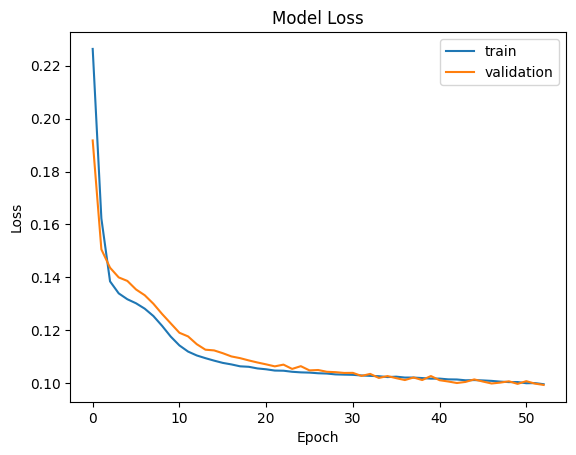

In [140]:
# plot model loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


- **Plot Accuracy**: Displays model's training and validation accuracy.


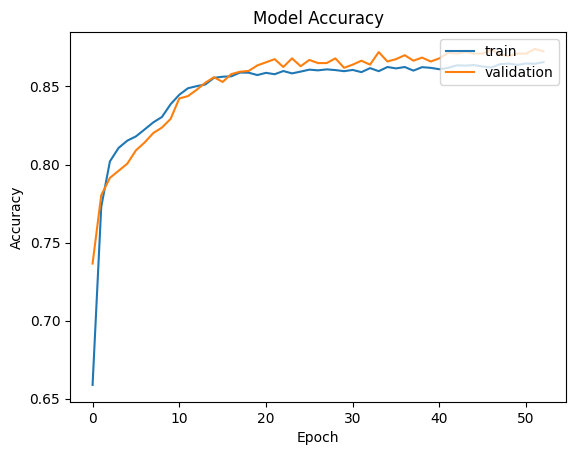

In [141]:
# plot model accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

- **Predictions**: Generates predictions on the validation set using the trained model.

In [142]:
# Make predictions on the validation set
y_pred2 = model2.predict(x_val_prep)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


- **Accuracy Calculation**: Determines the proportion of correctly predicted labels compared to true labels in the validation set, providing an assessment of model performance.

In [143]:
from sklearn.metrics import accuracy_score

# Convert predicted class probabilities to class labels
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Calculate accuracy
accuracy2 = accuracy_score(y_val_encoded, y_pred_classes2)
print("Accuracy:", accuracy2)

Accuracy: 0.6428211586901763


### Note: Improving Model Accuracy

A second neural network model will be designed to enhance accuracy. Adjustments to architecture, optimization strategies, regularization techniques, and hyperparameter tuning will be explored. Stay tuned for updates on the improved model's performance!


### Overview
- Sequential model with two hidden layers and an output layer.

### Network structure
- Input: 10 features.
- Hidden: Two layers, ***first:*** 64 neurons , ReLU activation,
***second:*** 32 neurons, ReLU activation.
- Output: Single neuron, sigmoid activation.

In [144]:
# Initialize the model object as a linear stack of layers
model3 = Sequential()

# Add the first hidden layer with 64 neurons and relu activation function
# The input will have 10 features.
model3.add(Dense(64, activation = 'relu', input_shape = (10,)))

# Add the second hidden layer with 32 neurons and relu activation function
model3.add(Dense(32, activation = 'relu'))

# Add the output layer with 1 neuron and a sigmoid activation function 
model3.add(Dense(1, activation='sigmoid'))


- **Model Summary**: Displays architecture and parameters of the neural network model.


In [145]:
model3.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)


- **Loss Function**: Measures prediction error for binary classification tasks.
- **Optimizer**: Adjusts model parameters to minimize loss during training.


In [146]:
from keras.optimizers import  Adam
from keras.callbacks import EarlyStopping

# Define the loss function
loss_function3 = 'binary_crossentropy' 
optimizer3 = Adam(learning_rate=0.001)


- **Compile Model**: Prepares model for training.


In [147]:
model3.compile(optimizer = optimizer3, loss = loss_function3,metrics=['accuracy'])

- **Early Stopping**: Halts training if validation loss stops decreasing, preventing overfitting.

In [148]:
# Early stopping callback
early_stopping_monitor3 = EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True)



- **Train Model**: Iteratively adjusts model parameters using training data to improve performance.


In [149]:
# Train the model
history3 = model3.fit(x_train_prep, y_train_encoded, epochs=100,
                     validation_data=(x_val_prep, y_val_encoded), callbacks=[early_stopping_monitor3])


Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7735 - loss: 0.4835 - val_accuracy: 0.8343 - val_loss: 0.3871
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.8446 - loss: 0.3613 - val_accuracy: 0.8489 - val_loss: 0.3639
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.8661 - loss: 0.3373 - val_accuracy: 0.8529 - val_loss: 0.3555
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8588 - loss: 0.3374 - val_accuracy: 0.8655 - val_loss: 0.3405
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.8638 - loss: 0.3287 - val_accuracy: 0.8620 - val_loss: 0.3470
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.8656 - loss: 0.3231 - val_accuracy: 0.8615 - val_loss: 0.3420
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.8689 - loss: 0.3145 - val_accuracy: 0.8670 - val_loss: 0.3300
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.8734 - loss: 0.311

- **Plot Loss**: Visualizes model training progress.

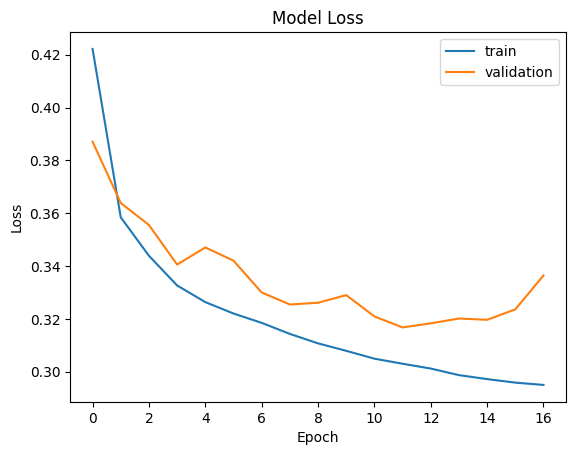

In [150]:
# plot model loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()


- **Plot Accuracy**: Displays model's training and validation accuracy.


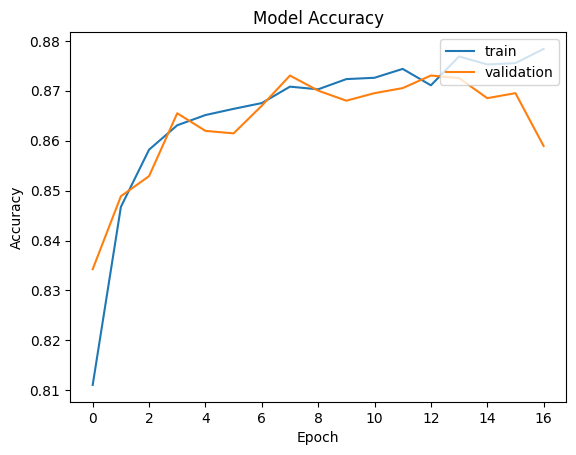

In [151]:
# plot model accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

- **Predictions**: Generates predictions on the validation set using the trained model.

In [152]:
# Make predictions on the validation set
y_pred3 = model3.predict(x_val_prep)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


- **Accuracy Calculation**: Determines the proportion of correctly predicted labels compared to true labels in the validation set, providing an assessment of model performance.

In [153]:
from sklearn.metrics import accuracy_score

# Convert predicted class probabilities to class labels
y_pred_classes3 = np.argmax(y_pred3, axis=1)

# Calculate accuracy
accuracy3 = accuracy_score(y_val_encoded, y_pred_classes3)
print("Accuracy:", accuracy3)

Accuracy: 0.6428211586901763


<a id="ann3"></a>
<font face="Times new roman" color= "#FF3A7D"><h3>Third Network</h3></font>
<font face ="times new roman"><u><h4><b>Network Structure:</b></h4></font></u>
<ul>
<li>Input layer: <b>10 nodes</b></li>
<li>2 Hidden layers: <b>10 nodes each</b>, Activation function: <code>ReLU</code></li>
<li>Output Layer: <b>1 node</b>, Activation function: <code>Sigmoid</code></li>
</ul>
<br><br>

We will create 2 neural networks, one with a constant learning rate which is `0.01`, the other using a `learning rate scheduler` and compare the results between the two in terms of accuracy and loss accross `100 epochs`
#### The first neural network: 
the baseline model with the constant learning rate of `0.01`

In [154]:
from keras.models import Sequential
from keras.layers import Dense
import keras 
import tensorflow as tf

def baseline_model():
    # instantiate the model
    model = Sequential()

    # add layers 
    # 1st hidden layer: 10 inputs, 10 outputs, relu
    model.add(Dense(10, activation='relu', input_shape = (10,)))
    # 2nd hidden layer: 10 inputs, 10 outputs, relu
    model.add(Dense(10, activation='relu'))
    # output layer 
    model.add(Dense(1, activation='sigmoid'))

    # define optimizer & learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # compile model and define loss function
    model.compile(optimizer= optimizer, loss= 'binary_crossentropy', metrics=['accuracy'])

    return model

***Train and evaluate the baseline model***

In [155]:
# create the model by calling the function
model1_nn = baseline_model()

# fit the model
history1_nn = model1_nn.fit(x_train_prep, y_train_encoded, validation_data = (x_val_prep, y_val_encoded), epochs=100)

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7711 - loss: 0.4752 - val_accuracy: 0.8529 - val_loss: 0.3652
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.8491 - loss: 0.3613 - val_accuracy: 0.8645 - val_loss: 0.3413
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.8537 - loss: 0.3433 - val_accuracy: 0.8579 - val_loss: 0.3442
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.8604 - loss: 0.3285 - val_accuracy: 0.8635 - val_loss: 0.3364
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.8574 - loss: 0.3414 - val_accuracy: 0.8685 - val_loss: 0.3241
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.8632 - loss: 0.3270 - val_accuracy: 0.8630 - val_loss: 0.3408
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.8704 - loss: 0.3175 - val_accuracy: 0.8635 - val_loss: 0.3345
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.8657 - loss: 0.3

In [156]:
# printing the model summary
model1_nn.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 695 (2.72 KB)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 464 (1.82 KB)

***Plotting a the curve of the training and validation accurracy***

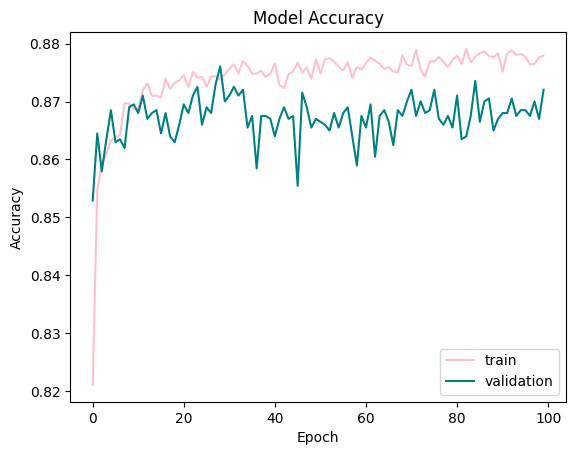

In [157]:
plt.plot(history1_nn.history['accuracy'], color = 'pink')
plt.plot(history1_nn.history['val_accuracy'], color = 'teal')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

***Plotting a the curve of the training and validation loss***

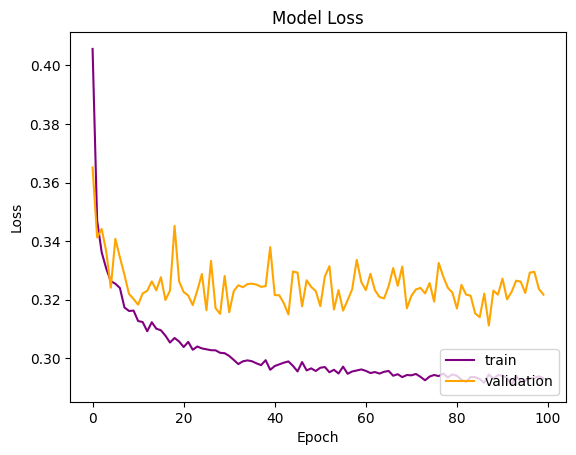

In [158]:
plt.plot(history1_nn.history['loss'], color = 'purple')
plt.plot(history1_nn.history['val_loss'], color = 'orange')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

#### Evaluate the model
By making predctions and calculating a few metrics like:
- accuracy
- precision
- recall

In [159]:
# evualuate the model and get the validation accuracy
scores1 = model1_nn.evaluate(x_val_prep, y_val_encoded)
scores1

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.8721 - loss: 0.3071


[0.32173585891723633, 0.872040331363678]

In [160]:
print('Validation accuracy as evaluated by the model: ', scores1[1])

Validation accuracy as evaluated by the model:  0.872040331363678


##### Repeating the process using a different optimizer 
We will repeat the same neural network structure using **Stochastic gradient descent** instead of **Adam**, and instead of of the constant learning rate of `0.01` we will use a decaying learning rate 

<font face="Times new roman" color="#f74f60"><h5>Decaying Learning rate</h5></font>
is a technique used in training neural networks that gradually reduces the learning rate over time. This helps prevent overfitting, stabilizes training, and fine-tunes weights for optimal performance.
<br><br>
<img src="lr decay.png" width = 400>

In [161]:
# define number of epochs
epochs = 100
# define initial learning rate 
learning_rate = 0.01
# define decaying rate
decay_rate =  learning_rate/epochs
# define momentum: controls the speed of decaying
momentum = 0.8

Defining the used optimizer in this model which will be the `stochastic gradient descent`

In [162]:
from keras.optimizers import SGD
from keras.callbacks import LearningRateScheduler

# define the stochastic gradient descent optimizer 
sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay= decay_rate, nesterov=False)  # nesterov is another form of momentum which we will not use 

In [163]:
from keras.models import Sequential
from keras.layers import Dense
import keras 
import tensorflow as tf
from keras.optimizers.schedules import PolynomialDecay

def decaying_lr_model():
    # instantiate the model
    model = Sequential()

    # add layers 
    # 1st hidden layer: 10 inputs, 10 outputs, relu
    model.add(Dense(10, activation='relu', input_shape = (10,)))
    # 2nd hidden layer: 10 inputs, 10 outputs, relu
    model.add(Dense(10, activation='relu'))
    # output layer 
    model.add(Dense(1, activation='sigmoid'))

    # compile model and define loss function
    model.compile(optimizer= sgd, loss= 'binary_crossentropy', metrics=['accuracy'])

    return model

Time to try the model

In [164]:
# create the model by calling the function
model2_nn = decaying_lr_model()
model2_nn.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 231 (924.00 B)

 Trainable params: 231 (924.00 B)

 Non-trainable params: 0 (0.00 B)

In [165]:
# define a function to perform the exponential decay 
def exp_decay(epoch):
    # decay th learning rate
    lrate = learning_rate*np.exp(-decay_rate*epoch)
    # return the learning rate after decay
    return lrate

In [166]:
# define the learning rate scheduler callback and pass the decay function
scheduler = LearningRateScheduler(exp_decay)
# define callback list to store the learning rates
callbacks_list = [scheduler]

history2_nn = model2_nn.fit(x_train_prep, y_train_encoded, epochs = 100, validation_data = (x_val_prep, y_val_encoded))

Epoch 1/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7230 - loss: 0.5679 - val_accuracy: 0.8020 - val_loss: 0.4310
Epoch 2/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.8252 - loss: 0.4026 - val_accuracy: 0.8202 - val_loss: 0.3968
Epoch 3/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.8353 - loss: 0.3769 - val_accuracy: 0.8312 - val_loss: 0.3822
Epoch 4/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.8509 - loss: 0.3548 - val_accuracy: 0.8504 - val_loss: 0.3700
Epoch 5/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.8524 - loss: 0.3520 - val_accuracy: 0.8579 - val_loss: 0.3515
Epoch 6/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.8606 - loss: 0.3404 - val_accuracy: 0.8574 - val_loss: 0.3553
Epoch 7/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.8581 - loss: 0.3407 - val_accuracy: 0.8700 - val_loss: 0.3392
Epoch 8/100
352/352 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.8588 - loss: 0.3

***Plotting a the curve of the training and validation accurracy***

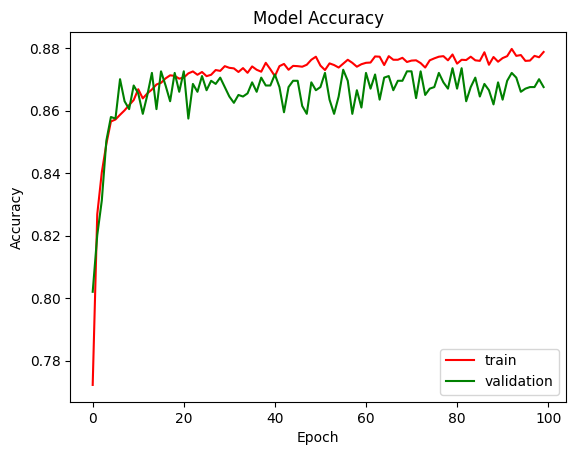

In [167]:
plt.plot(history2_nn.history['accuracy'], color = 'red')
plt.plot(history2_nn.history['val_accuracy'], color = 'green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

***Plotting a the curve of the training and validation loss***

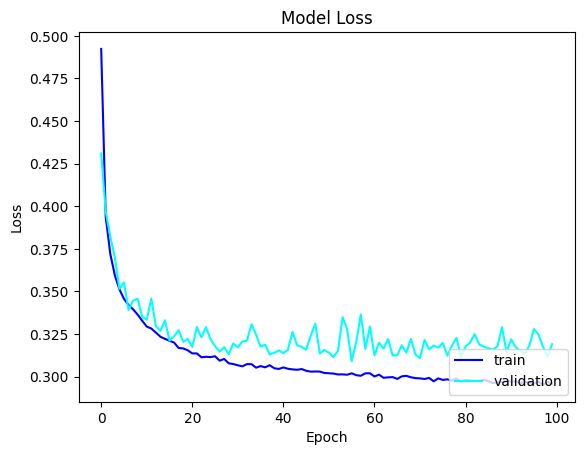

In [168]:
plt.plot(history2_nn.history['loss'], color = 'blue')
plt.plot(history2_nn.history['val_loss'], color = 'cyan')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [169]:
scores2 = model2_nn.evaluate(x_val_prep, y_val_encoded)
scores2

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - accuracy: 0.8729 - loss: 0.3117


[0.31914249062538147, 0.8675063252449036]

In [170]:
print('Validation accuracy as evaluated by the model: ', scores2[1])

Validation accuracy as evaluated by the model:  0.8675063252449036


### Comparing between the 2 networks 
When we look at the final test and train accuracy there seems to be no change to the outcome in terms of numbers, but let's compare the training and evaluation processes side by side

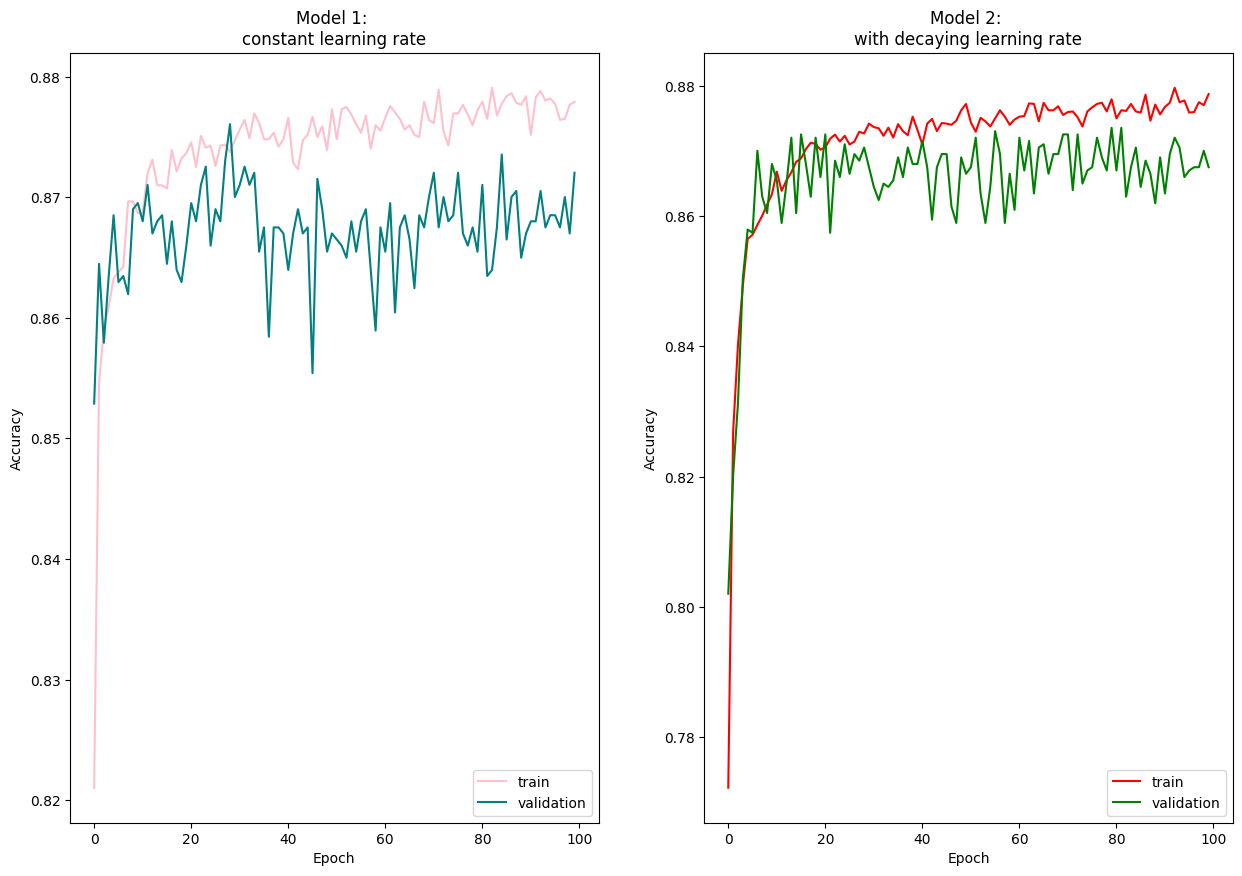

In [171]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(history1_nn.history['accuracy'], color = 'pink')
plt.plot(history1_nn.history['val_accuracy'], color = 'teal')
plt.title('Model 1: \nconstant learning rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history2_nn.history['accuracy'], color = 'red')
plt.plot(history2_nn.history['val_accuracy'], color = 'green')
plt.title('Model 2: \nwith decaying learning rate')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

`Observation:`<br>
Looking at the training process of the 2 models we find that the one with the decaying learning rate was a lot smoother with less overshooting which makes it a better approach in this case.

#### Using the second model (the better one) to make the predictions on the test set
Evaluate the model 

In [93]:
scores_final = model2_nn.evaluate(full_pipe_preprocessing.fit_transform(x_test),LabelEncoder().fit_transform(y_test))

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.8870 - loss: 0.2862


Make predictions using the test set and calculating a few metrics:
* accuracy
* f1 score
* recall
* precision

In [175]:
# make the predictions 
predictions_nn2 = model2_nn.predict(full_pipe_preprocessing.fit_transform(x_test))
predictions_nn2

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step


array([[0.12667711],
       [0.46272382],
       [0.70242846],
       ...,
       [0.85041714],
       [0.669132  ],
       [0.32140473]], dtype=float32)

In [176]:
# set a threshold for the probabilities produced by the sigmoid fun. (>=0.5 and <0.5)
predictions_nn2 = [1 if pred>=0.5 else 0 for pred in predictions_nn2]

In [177]:
# calculate metrics 
from sklearn.metrics import accuracy_score, classification_report
# calculating test accuracy
accuracy = accuracy_score(LabelEncoder().fit_transform(y_test), predictions_nn2)
print('Test accuracy: ', accuracy)

Test accuracy:  0.8702397743300423


In [178]:
print('\t\t\tclassification report:\n\n', classification_report(LabelEncoder().fit_transform(y_test), predictions_nn2))

			classification report:

               precision    recall  f1-score   support

           0       0.86      0.95      0.90      3673
           1       0.88      0.73      0.80      1999

    accuracy                           0.87      5672
   macro avg       0.87      0.84      0.85      5672
weighted avg       0.87      0.87      0.87      5672



<hr>